Deep Learning using Rectified Linear Units (ReLU)
===

*This notebook is a part of an on-going research of the same title.*

## MNIST classification

In which we use the MNIST dataset for evaluating our CNN-ReLU model. We first employ data preprocessing techniques such as normalization through standardization, and dimensionality reduction through principal component analysis (PCA).

We load the Fashion-MNIST dataset the same way we load MNIST.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

/usr/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('/home/darth/MNIST_data', one_hot=True)

Extracting /home/darth/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/darth/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/darth/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/darth/MNIST_data/t10k-labels-idx1-ubyte.gz


We load `numpy` for handling data, and `matplotlib` and `seaborn` for data visualization.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

Before employing our CNN-ReLU model on this classification problem, we attempt to reduce the dimensionality of our data. But first, we visualize the *cumulative explained variance*, to determine which features (in this case, pixels) most describe the images.

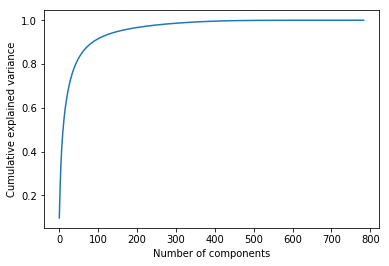

In [4]:
pca = PCA(n_components=784)
pca.fit(mnist.train.images)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

It may be noticed that the cumulative explained variance is high around 100, but still changing slightly around 100-200. But, we still choose an arbitrary value of 256 for principal component selection.

But first, we normalize the training dataset using `StandardScaler`. Then we apply PCA for dimensionality reduction on the dataset.

In [5]:
from sklearn.preprocessing import StandardScaler

We fit the normalization function to the training dataset, so as to not get any information from the testing dataset.

In [6]:
scaler = StandardScaler().fit(mnist.train.images)

After fitting the normalization function to the training dataset alone, we transform both training and testing dataset.

In [7]:
normalized_train = scaler.transform(mnist.train.images)
normalized_test = scaler.transform(mnist.test.images)

We now select the 256 principal components.

In [8]:
pca = PCA(n_components=256)

Like in normalization, we only fitted the PCA to the training dataset.

In [9]:
reduced_train = pca.fit_transform(normalized_train)

Then we apply the fitted PCA to the testing dataset, to have them both on the same vector space.

In [10]:
reduced_test = pca.transform(normalized_test)

We list the class names in the Fashion-MNIST dataset for reports later.

In [11]:
class_names = [str(digit) for digit in range(10)]

## VGG-like Convnet + ReLU + Adam + Categorical Cross-entropy

We load the VGG-like Convnet from Keras examples, with an amendment of using the ReLU function as its classification function, i.e. $max(0, \hat{y})$.

In [12]:
from models.cnn_keras import CNN

Using TensorFlow backend.


We use ReLU as activation function for each convolutional layer, softmax cross-entropy for loss function, and Adam as optimization algorithm.

In [13]:
model = CNN(activation='relu',
            classifier='relu',
            input_shape=(16, 16, 1),
            loss='categorical_crossentropy',
            num_classes=mnist.train.labels.shape[1],
            optimizer='adam',
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)       

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [14]:
model.train(batch_size=256,
            n_splits=10,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 16, 16, 1)),
            train_labels=mnist.train.labels,
            epochs=32)

loss : 1.9060128301398311, acc : 0.32963837901722315
loss : 1.4318902588488513, acc : 0.5091768125718277
loss : 1.362783239967884, acc : 0.5942213337366827
loss : 0.8257899198037331, acc : 0.7495911319797827
loss : 1.222473526516734, acc : 0.7038720233118376
loss : 0.4512576775334098, acc : 0.8729090907790444
loss : 0.49083630082824015, acc : 0.8601818182685158
loss : 0.34528968995411613, acc : 0.9032199380288064
loss : 0.30161443973038743, acc : 0.912663755545276
loss : 0.279967466075669, acc : 0.9171823807790317
CV acc : 0.7352656664018029, CV stddev : +/- 0.19080254644405553


Evaluate the trained CNN-ReLU model.

In [15]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 16, 16, 1)),
                                          test_labels=mnist.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 1s 82us/step
Test loss : 0.2987786193549633
Test accuracy : 0.9174


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [16]:
print(report)

             precision    recall  f1-score   support

          0       0.97      0.97      0.97       980
          1       0.99      0.98      0.98      1135
          2       0.91      0.91      0.91      1032
          3       0.90      0.90      0.90      1010
          4       0.88      0.94      0.91       982
          5       0.87      0.87      0.87       892
          6       0.95      0.96      0.96       958
          7       0.93      0.89      0.91      1028
          8       0.86      0.91      0.88       974
          9       0.91      0.85      0.88      1009

avg / total       0.92      0.92      0.92     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

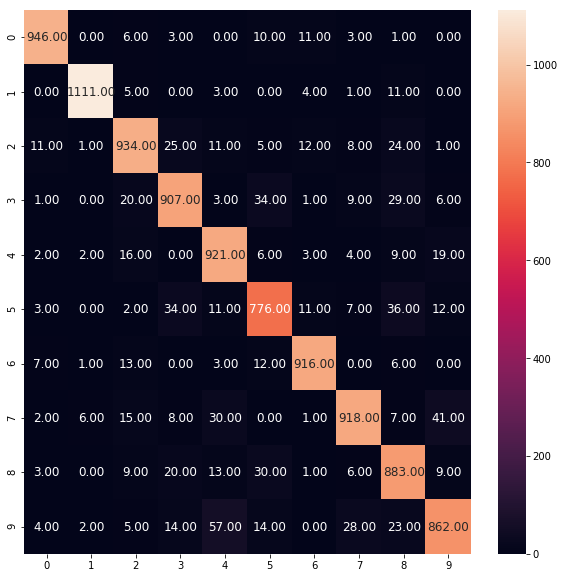

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')

## 3-layer DNN + ReLU + Adam + Categorical Cross-entropy

We load a feed-forward neural network with ReLU activation function in its hidden layers, and ReLU as its classifier.

In [18]:
from models.dnn_keras import DNN

We use softmax cross-entropy for loss function, and Adam as optimization algorithm.

In [19]:
model = DNN(activation='relu',
            classifier='relu',
            dropout_rate=0.1,
            loss='categorical_crossentropy',
            optimizer='adam',
            num_classes=mnist.train.labels.shape[1],
            num_features=reduced_train.shape[1],
            num_neurons=[512, 512, 512],
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)             

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [20]:
model.train(batch_size=256,
            n_splits=10,
            epochs=32,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 256)),
            train_labels=mnist.train.labels)

loss : 0.2773061098412676, acc : 0.9582046156750145
loss : 0.2668585197476448, acc : 0.9607486825476295
loss : 0.16808589326039325, acc : 0.9765582409594766
loss : 0.09966248333722814, acc : 0.9831001270408741
loss : 0.09023646836480351, acc : 0.9874568260316307
loss : 0.11127364887788338, acc : 0.9827272727272728
loss : 0.0486492724756934, acc : 0.9923636363636363
loss : 0.05302298257256529, acc : 0.9934509732581408
loss : 0.03539979776651261, acc : 0.9943595342066958
loss : 0.05594293203618887, acc : 0.9932653804149982
CV acc : 0.982223528922537, CV stddev : +/- 0.01263591976351954


Evaluate the trained DNN-ReLU model.

In [21]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 256)),
                                          test_labels=mnist.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 0s 43us/step
Test loss : 0.2416184113426999
Test accuracy : 0.9777


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [22]:
print(report)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.98      0.98      0.98      1010
          4       0.98      0.98      0.98       982
          5       0.98      0.98      0.98       892
          6       0.99      0.97      0.98       958
          7       0.97      0.97      0.97      1028
          8       0.97      0.97      0.97       974
          9       0.98      0.96      0.97      1009

avg / total       0.98      0.98      0.98     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

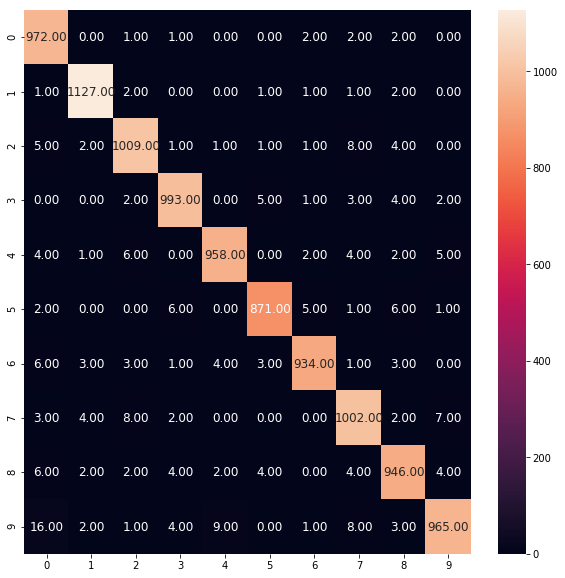

In [23]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')

## VGG-like Convnet + Softmax + Adam + Categorical Cross-entropy

We load the VGG-like Convnet from Keras examples.

In [24]:
from models.cnn_keras import CNN

Use ReLU as activation function for each convolutional layer, softmax cross-entropy for loss function, Adam as optimization algorithm, and the conventional softmax classifier.

In [25]:
model = CNN(activation='relu',
            classifier='softmax',
            input_shape=(16, 16, 1),
            loss='categorical_crossentropy',
            num_classes=mnist.train.labels.shape[1],
            optimizer='adam',
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)       

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [26]:
model.train(batch_size=256,
            n_splits=10,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 16, 16, 1)),
            train_labels=mnist.train.labels,
            epochs=32)

loss : 0.18004129544325617, acc : 0.948391786309214
loss : 0.1589738540134765, acc : 0.9525713245694949
loss : 0.10859627948267317, acc : 0.967835725967654
loss : 0.083434741659753, acc : 0.9731055787860449
loss : 0.06931501010517405, acc : 0.9783675695328122
loss : 0.07144928369467908, acc : 0.9785454546321523
loss : 0.06448305953463371, acc : 0.976909090909091
loss : 0.05275973127211183, acc : 0.9810805893148187
loss : 0.052521931800043706, acc : 0.9836244541484717
loss : 0.04894417793682224, acc : 0.982708409173644
CV acc : 0.9723139983343397, CV stddev : +/- 0.011798906182429186


Evaluate the trained CNN-ReLU model.

In [27]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 16, 16, 1)),
                                          test_labels=mnist.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 1s 64us/step
Test loss : 0.20139129625365604
Test accuracy : 0.9536


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [28]:
print(report)

             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.99      0.99      0.99      1135
          2       0.93      0.94      0.94      1032
          3       0.94      0.94      0.94      1010
          4       0.96      0.96      0.96       982
          5       0.93      0.93      0.93       892
          6       0.97      0.97      0.97       958
          7       0.96      0.96      0.96      1028
          8       0.96      0.92      0.94       974
          9       0.94      0.94      0.94      1009

avg / total       0.95      0.95      0.95     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

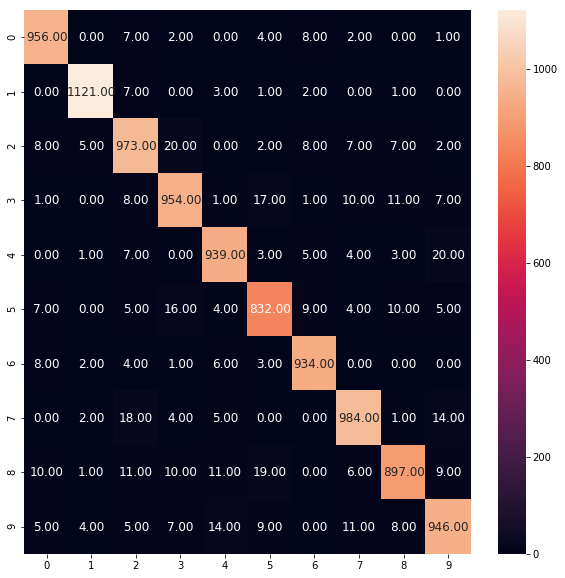

In [29]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')

## 3-layer DNN + Softmax + Adam + Categorical Cross-entropy

We load a feed-forward neural network with ReLU activation function in its hidden layers.

In [30]:
from models.dnn_keras import DNN

We use softmax cross-entropy for loss function, and Adam as optimization algorithm, and the conventional softmax classifier.

In [31]:
model = DNN(activation='relu',
            classifier='softmax',
            dropout_rate=0.1,
            loss='categorical_crossentropy',
            optimizer='adam',
            num_classes=mnist.train.labels.shape[1],
            num_features=reduced_train.shape[1],
            num_neurons=[512, 512, 512],
            return_summary=True)

<log> Building graph...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)             

Train on batch size of $256$, with 10-fold cross validation, with each fold running 32 epochs.

In [32]:
model.train(batch_size=256,
            n_splits=10,
            epochs=32,
            validation_split=0.,
            verbose=0,
            train_features=np.reshape(reduced_train, (-1, 256)),
            train_labels=mnist.train.labels)

loss : 0.15638387243689447, acc : 0.9741958929867218
loss : 0.06398383073884104, acc : 0.9889151370354226
loss : 0.043993184690360815, acc : 0.9929129565691441
loss : 0.028511127950100766, acc : 0.9963656187534072
loss : 0.029963719598071613, acc : 0.994546446100709
loss : 0.03589841662340041, acc : 0.9952727272727273
loss : 0.040193850687963925, acc : 0.9956363636363637
loss : 0.031082185303349625, acc : 0.9970893213504745
loss : 0.0598909051698189, acc : 0.995633187686165
loss : 0.025034054021619373, acc : 0.9979978157990536
CV acc : 0.9928565467190188, CV stddev : +/- 0.006667468117667432


Evaluate the trained DNN-ReLU model.

In [33]:
report, confusion_matrix = model.evaluate(batch_size=256,
                                          test_features=np.reshape(reduced_test, (-1, 256)),
                                          test_labels=mnist.test.labels,
                                          class_names=class_names)

10000/10000 [==============================] - 1s 50us/step
Test loss : 0.30003574385759185
Test accuracy : 0.9798


Print the classification report which consists of the precision, recall, and f1-score for each class.

In [34]:
print(report)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.97      0.98      1032
          3       0.97      0.99      0.98      1010
          4       0.98      0.98      0.98       982
          5       0.99      0.96      0.97       892
          6       0.98      0.99      0.98       958
          7       0.97      0.98      0.97      1028
          8       0.98      0.98      0.98       974
          9       0.97      0.97      0.97      1009

avg / total       0.98      0.98      0.98     10000



Print the confusion matrix for the predicted labels on the Fashion-MNIST test dataset.

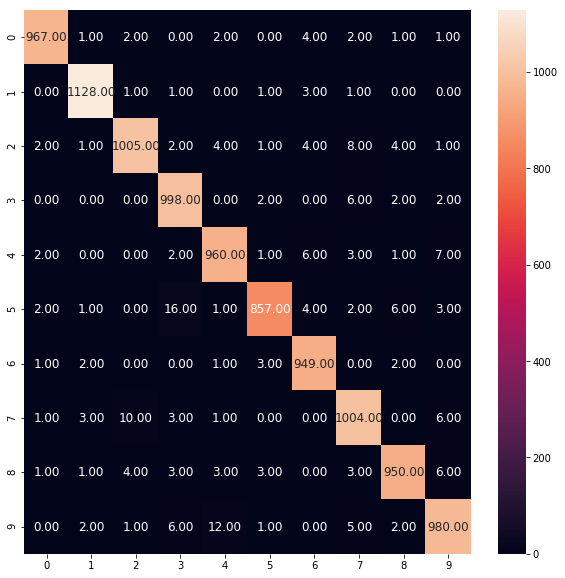

In [35]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, annot_kws={'size': 12}, fmt='.2f')